# Autoencoders

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial

from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from fastprogress import progress_bar,master_bar
from miniai.datasets import *
from miniai.training import *
from miniai.conv import *

In [ ]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Data

Get FashionMnist dataset from HF

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name, ignore_verifications=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Create and inplace transforms to cast each image inside a dictionary to a tensor.

In [ ]:
@inplace
def transformi(b): b[x] = # add code here

In [ ]:
bs = 256
tds = dsd.with_transform(transformi)

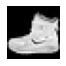

In [ ]:
ds = tds['train']
img = ds[0]['image']
show_image(img, figsize=(1,1));

In [ ]:
cf = collate_dict(ds)

In [ ]:
o = [{'image': 1, 'label': 2}, {'image': 3, 'label': 4}]
cf(o)

(tensor([1, 3]), tensor([2, 4]))

In [ ]:
# combine moving to device with collate function
def collate_(b): return # add code here

# return data_loaders for each of the items in a Dataset
def data_loaders(dsd, bs, **kwargs): return # add code here

In [ ]:
dls = data_loaders(tds, bs, collate_fn=collate_)

In [ ]:
dt = dls['train']
dv = dls['test']

xb,yb = next(iter(dt))

In [ ]:
labels = ds.features[y].names

In [ ]:
labels

['T - shirt / top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Create a label getter using `itemgetter` for target values

In [ ]:
lbl_getter = # add code here
titles = # add code here

Show images in a grid using `show_images`

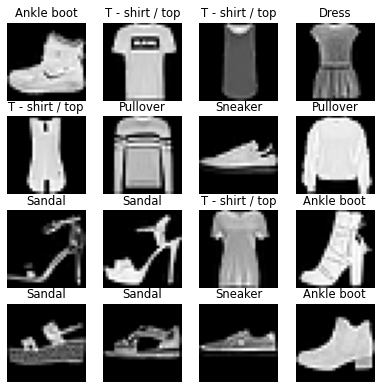

In [ ]:
mpl.rcParams['figure.dpi'] = 70
show_images(xb[:16], imsize=1.7, titles=titles)

## Warmup - classify

In [ ]:
from torch import optim

bs = 256
lr = 0.4

In [ ]:
cnn = nn.Sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,16),           #2x2
    conv(16,10, act=False),
    nn.Flatten()).to(def_device)

In [ ]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss,acc = fit(5, cnn, F.cross_entropy, opt, dt, dv)

0 0.7675590258598327 0.7258
1 0.5698014464855194 0.799
2 0.49548909254074097 0.824
3 0.526043289756775 0.8119
4 0.53454775390625 0.8106


This takes quite some time because each image is being converted one by one into a tensor and all of the work is done just by a single cpu.

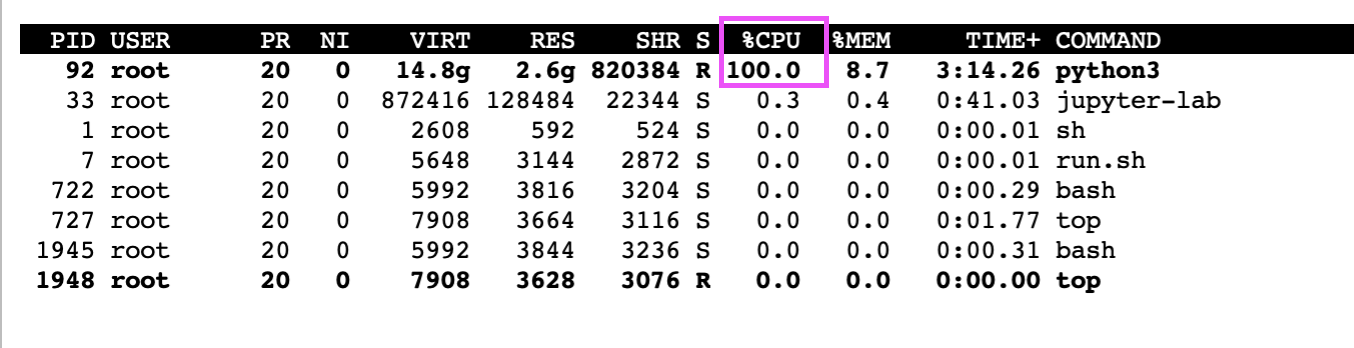

Unfortunately little can be done about this without rewriting the `fit` function.

In [ ]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

## Autoencoder

For the autoencoder we want to create a pipeline that applies convolutions to reduce iamge size and that apply deconvolutions (UpsamplingNearest2d) to return out initial image. A well trained model will result in an image that is very similar to the initial one.

UpsamplingNearest2d copies each pixel given number of times effectively increasing the image size.

In [ ]:
def deconv(ni, nf, ks=3, act=True):
    # UpsamplingNearest2d followed by stride-1 convolution for training the weights
    layers = 
    
    # optionally followed by activation layer
    
    return nn.Sequential # add code here

In [ ]:
def eval(model, loss_func, valid_dl, epoch=0):
    # set model to evaluation mode and calculate the loss on a validation dataset
    # target is the image itself
   
    # add code here

    print(epoch, f'{tot_loss/count:.3f}')

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # training part of the loop
  

        # evaluation part of the loop
        

In [ ]:
# sample autoencoder model.
# keep note of the shapes used 
ae = nn.Sequential(   #28x28
    #32x32
    #16x16
    #8x8
    #4x4
    #8x8
    #16x16
    #32x32
    #28x28
    nn.Sigmoid()
).to(def_device)

In [ ]:
eval(ae, F.mse_loss, dv)

0 0.182


In [ ]:
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.121
1 0.050
2 0.034
3 0.029
4 0.027


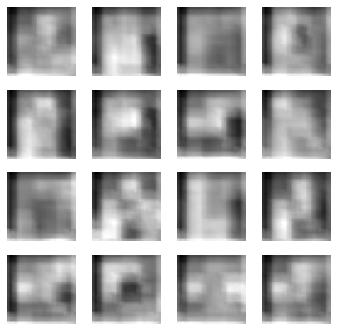

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

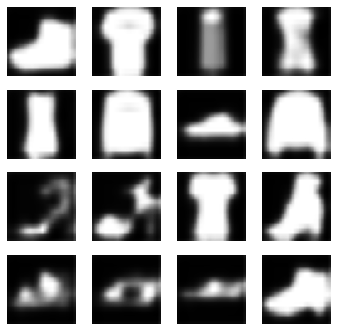

In [ ]:
p = ae(xb)
show_images(p[:16].data.cpu(), imsize=1.5)

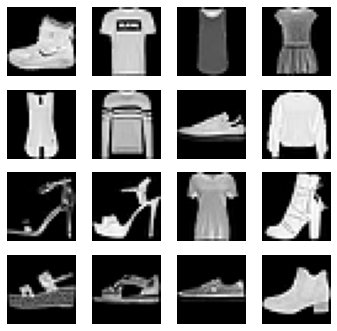

In [ ]:
show_images(xb[:16].data.cpu(), imsize=1.5)